In [1]:
import os
import sys
import time
import itertools

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize

In [3]:
import autograd
import autograd.numpy as ag_np

from autograd.scipy.special import expit as ag_logistic_sigmoid

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

In [5]:
# Custom visualization routines
import visuals

# Wrappers around scipy.optimize solvers
import solvers

# Utility functions to compute true TP/FP/TN/FN and predict score for each example
from binary_clf_utils import calc_binary_clf_perf, calc_decision_score

In [6]:
# Load toydata generating module
import toydata

In [7]:
# Load modeling modules
import BCE
import SurrogateSigmoid
import SurrogateHinge

In [8]:
figsize = (5, 5)

## Create Toy Data

In [9]:
x_ND, y_N, x_pos_ND, y_pos_N, x_neg_ND, y_neg_N = toydata.create_toy_dataset()

In [10]:
N = x_ND.shape[0]
Npos = x_pos_ND.shape[0]
Nneg = x_neg_ND.shape[0]

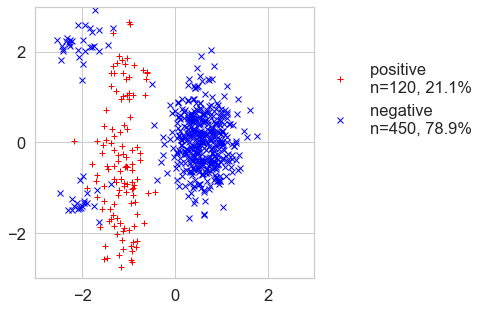

In [11]:
f, axs = plt.subplots(1, 1, figsize=figsize)
axs.plot(x_pos_ND[:,0], x_pos_ND[:,1], 'r+', label='positive \nn=%2d, %.1f%%' % (Npos, 100*Npos/N))
axs.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'bx', label='negative \nn=%2d, %.1f%%' % (Nneg, 100*Nneg/N))
axs.set_xlim([-3, 3]); axs.set_xticks([-2, 0, 2]);
axs.set_ylim([-3, 3]); axs.set_yticks([-2, 0, 2]);
axs.legend(
    loc='lower left',
    bbox_to_anchor= (1.01, 0.5),
    borderaxespad=0,
    frameon=False);

## Plan of Attack


We'd like to train a linear classifier on the toy dataset above.

We want this classifier to achieve some desired precision (set in the `alpha = ____` line below).

We wish to try 3 different objectives for solving this problem:

* BCE : Binary cross entropy
* SurrogateHinge : From Eban et al.
* SurrogateSigmoid : From this work

BCE is a convex problem, so we can just run it once and report how well it does.

The other two methods (Hinge, Sigmoid) are designed for a constrained optimization problem:

$$
    \text{argmin}_w f(w)
    \\
    \text{s.t.}~~ g(w) < 0
$$
where each one defines different lower/upper bounds used to define $f$ and $g$.

We transform the tough constrained problem into a standard unconstrained problem via the penalty method as:

$$
    \text{argmin}_w f(w) + \lambda \cdot \text{max}(g(w), 0)
$$

We'll try several logarithmically increasing values of $\lambda$.

At each $\lambda$, we'll try many initializations (20), drawing each entry of $w$ uniformly between -3 to +3.

Across all runs (all $\lambda$ and all initializations) we want to keep the best run.



We need to use a "common" loss across all tried $\lambda$ values so that solutions can be compared fairly. We'll grade each result's candidate solution $w'$ in terms of the following loss:

$$
    f(w') + 100000 \cdot  \text{max}(g(w'), 0)
$$

This way, any solution that does not satisfy the constraint is sure to have a huge value (here, minimization is good).

The function `calc_common_loss_from_ans_dict` defined below computes this "common" loss.

In [12]:
def calc_common_loss_from_ans_dict(ans_dict):
    k = ans_dict
    return (k['f']
        + 100000 * np.maximum(0.0, k['g']) 
        + (np.inf if k['recall']<0.01 else 0.0) # avoid degenerate solutions with no recall
       )

## Define problem to solve

In [13]:
alpha = 0.8      # precision to enforce. Used by both Sigmoid and Hinge methods

# Hyperparameters for our Sigmoid method                  
delta = 0.05     # small lift to zero-one loss to allow positive TP lower bounds
gamma = 3.0      # tolerance for the height of the sigmoid bounds (gamma * delta)
epsilon = 0.5    # tolerance for the width of the sigmoid bounds

In [14]:
sigm__lamb_candidate_values = np.logspace(-3, 3, 5)
hin__lamb_candidate_values = np.logspace(-3, 3, 20)

In [15]:
random_state = 8675309

## Try standard Binary Cross Entropy

In [16]:
bce_loss, bce_grad = BCE.make_loss_and_grad_for_dataset(x_ND, y_N)

In [17]:
best_w_D__bce, best_loss__bce, best_issat__bce, answers__bce = solvers.solve_minimimization_multiple_tries_with_lbfgs(
    x_ND, y_N, bce_loss, bce_grad, n_inits=5, alpha=alpha, random_state=random_state)

init 00    1.87   1.51  -0.86 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 01   -1.79  -0.55  -2.51 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 02   -1.71  -0.52  -2.89 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 03    1.02   0.60   2.52 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68
init 04   -0.94   0.33   1.31 | loss      0.31074 final w   -1.69  -0.62  -2.03 | recall 0.64 prec 0.68


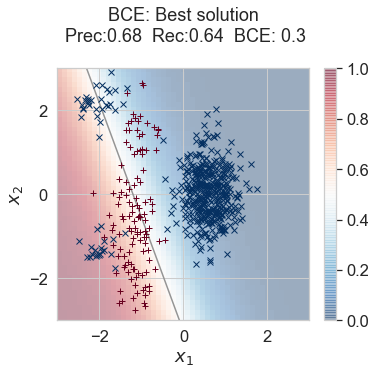

In [18]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_w_D__bce, x_ND, y_N,
    title_str='BCE: Best solution',
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

## Proposed sigmoid surrogate loss

In [19]:
n_inits = 20

best_w_D__sigm_by_lam = {}
best_loss__sigm_by_lam = {}
answers__sigm_by_lam = {}

for lamb in sigm__lamb_candidate_values:
    print("")
    print("Lambda %.3g" % lamb)
    print("-----------")
    sigm_loss, sigm_grad, sigm_tp, sigm_fp = SurrogateSigmoid.make_loss_and_grad_for_dataset(
        x_ND, y_N, lamb=lamb, alpha=alpha,
        l2_penalty_strength=0.00001,
        gamma=gamma, delta=delta, epsilon=epsilon)
    
    best_w_D__sigm_by_lam[lamb], best_loss__sigm_by_lam[lamb], _, answers__sigm_by_lam[lamb] = \
        solvers.solve_minimimization_multiple_tries_with_lbfgs(
            x_ND, y_N, sigm_loss, sigm_grad,
            calc_FPUB=sigm_fp,
            calc_TPLB=sigm_tp,
            n_inits=n_inits, random_state=random_state,
            keep_satisifiers_only=True,
            alpha=alpha, gamma=gamma, delta=delta, lamb=lamb)


Lambda 0.001
-----------
FPUB
slope      10.8848354
intercept  2.3513753
TPLB
slope      10.8848354
intercept -3.0910424
init 00    1.87   1.51  -0.86 | loss     -0.23988 final w  -41.82   6.60 -13.36 | recall 0.99 prec 0.70
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 137.0 FP =  52.0
  surrogate TP   >= 136.8 FP<=  59.8
  surrogate  f     -136.85000  g   102.35000  l2   0.01792
init 01   -1.79  -0.55  -2.51 | loss     -0.24192 final w   -9.77  -0.62  -3.81 | recall 1.00 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 138.0 FP =  53.0
  surrogate TP   >= 138.0 FP<=  60.9
  surrogate  f     -137.99954  g   105.78332  l2   0.00096
init 02   -1.71  -0.52  -2.89 | loss     -0.24188 final w   -4.93  -0.58  -0.92 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 138.0 FP =  58.0
  surrogate TP   >= 138.0 FP<=  66.8
  surrogate  f     -137.99984  g   129.19215  l2   0.00025
init 03    1.02   0.60   2.52 | loss     -0.238

init 13    1.88   1.65   0.18 | loss     -0.23064 final w  -82.96   3.71 -54.23 | recall 0.97 prec 0.70
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 135.0 FP =  50.0
  surrogate TP   >= 134.5 FP<=  57.5
  surrogate  f     -134.55000  g   95.45000  l2   0.06896
init 14   -0.58  -2.92   0.31 | loss     -0.23698 final w  -30.26  -1.85 -14.07 | recall 1.00 prec 0.71
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 138.0 FP =  50.0
  surrogate TP   >= 138.0 FP<=  57.5
  surrogate  f     -137.99891  g   92.02784  l2   0.00919
init 15   -2.11   0.91   1.77 | loss     -0.23689 final w  -19.76  -1.02  -8.90 | recall 1.00 prec 0.71
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 138.0 FP =  50.0
  surrogate TP   >= 138.0 FP<=  57.9
  surrogate  f     -137.98558  g   93.48223  l2   0.00392
init 16    2.50   1.34  -2.13 | loss      0.00000 final w    0.99   0.38  -3.86 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP+gd =  18.0 FP

init 02   -1.71  -0.52  -2.89 | loss     -0.17952 final w  -35.74 -31.53 -30.16 | recall 0.74 prec 0.80
meets constraint that prec >= 0.80 ? YES
       true TP+gd = 107.0 FP =  22.0
  surrogate TP   >= 102.3 FP<=  25.6
  surrogate  f     -102.34780  g  -0.00006  l2   0.02272
init 03    1.02   0.60   2.52 | loss      3.44133 final w   53.48  73.85 -121.48 | recall 0.02 prec 0.12
meets constraint that prec >= 0.80 ? NO
       true TP+gd =  20.0 FP =  14.0
  surrogate TP   >=   2.3 FP<=  16.1
  surrogate  f     -2.30000  g   62.10000  l2   0.08314
init 04   -0.94   0.33   1.31 | loss      4.92775 final w  -23.74  -0.27 -12.66 | recall 0.99 prec 0.70
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 137.0 FP =  50.0
  surrogate TP   >= 136.8 FP<=  57.5
  surrogate  f     -136.84996  g   93.15007  l2   0.00564
init 05   -1.93   2.57   1.57 | loss      4.86196 final w  -45.41  -2.93 -21.46 | recall 1.00 prec 0.71
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 138.0 FP 

init 14   -0.58  -2.92   0.31 | loss     -0.16430 final w   -4.34  -3.37  -4.84 | recall 0.69 prec 0.81
meets constraint that prec >= 0.80 ? YES
       true TP+gd = 101.0 FP =  20.0
  surrogate TP   >=  93.7 FP<=  23.4
  surrogate  f     -93.65053  g  -0.00161  l2   0.00030
init 15   -2.11   0.91   1.77 | loss    161.16147 final w  -56.79  -3.64 -26.83 | recall 1.00 prec 0.71
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 138.0 FP =  50.0
  surrogate TP   >= 138.0 FP<=  57.5
  surrogate  f     -138.00000  g   92.00000  l2   0.03238
init 16    2.50   1.34  -2.13 | loss      0.00000 final w    0.99   0.38  -3.86 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP+gd =  18.0 FP =   0.0
  surrogate TP   >=   0.0 FP<=   0.0
  surrogate  f     -0.00000  g   0.00000  l2   0.00001
init 17   -2.60   1.11  -2.04 | loss    163.18098 final w  -30.35  -0.49 -15.97 | recall 0.99 prec 0.70
meets constraint that prec >= 0.80 ? NO
       true TP+gd = 137.0 FP =  

In [20]:
# Search across all lambdas and initializations to find the best solution
ranked_answers__sigm = sorted(itertools.chain(*answers__sigm_by_lam.values()),
                     key=calc_common_loss_from_ans_dict,
                     reverse=False)
best_result__sigm = ranked_answers__sigm[0]

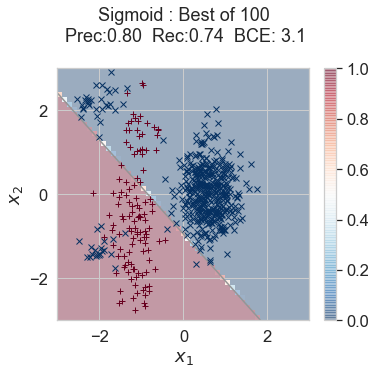

In [21]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_result__sigm['w_D'], x_ND, y_N,
    title_str='Sigmoid : Best of %d' % len(ranked_answers__sigm),
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

## Eban et al's Hinge surrogate loss


In [22]:
n_inits = 20
n_lam_values = 20

best_w_D__hin_by_lam = {}
best_loss__hin_by_lam = {}
answers__hin_by_lam = {}

for lamb in hin__lamb_candidate_values:
    print("")
    print("Lambda %.3g" % lamb)
    print("-----------")
    hin_loss, hin_grad, hin_tp, hin_fp = SurrogateHinge.make_loss_and_grad_for_dataset(
        x_ND, y_N, lamb=lamb, alpha=alpha,
        l2_penalty_strength=0.00001)
    
    best_w_D__hin_by_lam[lamb], best_loss__hin_by_lam[lamb], _, answers__hin_by_lam[lamb] = \
        solvers.solve_minimimization_multiple_tries_with_lbfgs(
            x_ND, y_N, hin_loss, hin_grad,
            calc_FPUB=hin_fp,
            calc_TPLB=hin_tp,
            n_inits=n_inits, random_state=random_state,
            keep_satisifiers_only=True, alpha=alpha, lamb=lamb)


Lambda 0.001
-----------
init 00    1.87   1.51  -0.86 | loss     -0.20843 final w   -2.58  -0.14  -0.26 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 120.0 FP<= 328.1
  surrogate  f     -120.00000  g   1192.34031  l2   0.00007
init 01   -1.79  -0.55  -2.51 | loss     -0.20824 final w   -3.13  -0.15  -0.50 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 120.0 FP<= 355.9
  surrogate  f     -120.00000  g   1303.58479  l2   0.00010
init 02   -1.71  -0.52  -2.89 | loss     -0.20826 final w   -3.11  -0.17  -0.52 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 120.0 FP<= 352.4
  surrogate  f     -120.00000  g   1289.71935  l2   0.00010
init 03    1.02   0.60   2.52 | loss     -0.20851 final w   -2.29  -0.15  -0.14 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ?

init 10    2.34  -0.63  -0.87 | loss     -0.20635 final w   -2.28  -0.15  -0.14 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  59.0
  surrogate TP   >= 120.0 FP<= 317.3
  surrogate  f     -119.99999  g   1149.20095  l2   0.00005
init 11    1.47  -1.62  -2.79 | loss     -0.20635 final w   -2.27  -0.15  -0.14 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  59.0
  surrogate TP   >= 120.0 FP<= 317.3
  surrogate  f     -120.00000  g   1149.38633  l2   0.00005
init 12    2.35   0.52  -2.03 | loss     -0.20635 final w   -2.27  -0.15  -0.14 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  59.0
  surrogate TP   >= 120.0 FP<= 317.3
  surrogate  f     -120.00000  g   1149.16935  l2   0.00005
init 13    1.88   1.65   0.18 | loss     -0.20635 final w   -2.27  -0.15  -0.14 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 12

init 03    1.02   0.60   2.52 | loss     -0.19389 final w   -1.98   0.03  -0.29 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 119.3 FP<= 277.2
  surrogate  f     -119.28481  g   989.52052  l2   0.00004
init 04   -0.94   0.33   1.31 | loss     -0.19389 final w   -2.00   0.03  -0.30 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 119.3 FP<= 276.9
  surrogate  f     -119.27587  g   988.41740  l2   0.00004
init 05   -1.93   2.57   1.57 | loss     -0.19390 final w   -2.00   0.03  -0.30 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  58.0
  surrogate TP   >= 119.3 FP<= 277.0
  surrogate  f     -119.27783  g   988.59554  l2   0.00004
init 06   -2.28   0.81  -2.25 | loss     -0.19389 final w   -1.99   0.03  -0.29 | recall 1.00 prec 0.67
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0

init 13    1.88   1.65   0.18 | loss     -0.17858 final w   -1.75  -0.07  -0.41 | recall 1.00 prec 0.68
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  56.0
  surrogate TP   >= 116.8 FP<= 234.1
  surrogate  f     -116.81184  g   819.52619  l2   0.00003
init 14   -0.58  -2.92   0.31 | loss     -0.17859 final w   -1.79  -0.10  -0.41 | recall 1.00 prec 0.68
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  57.0
  surrogate TP   >= 117.1 FP<= 237.9
  surrogate  f     -117.09664  g   834.63806  l2   0.00003
init 15   -2.11   0.91   1.77 | loss     -0.17859 final w   -1.76  -0.08  -0.41 | recall 1.00 prec 0.68
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  57.0
  surrogate TP   >= 116.9 FP<= 235.8
  surrogate  f     -116.94070  g   826.34937  l2   0.00003
init 16    2.50   1.34  -2.13 | loss     -0.17859 final w   -1.77  -0.09  -0.40 | recall 1.00 prec 0.68
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0

init 03    1.02   0.60   2.52 | loss     -0.10133 final w   -1.61  -0.13  -0.60 | recall 1.00 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  53.0
  surrogate TP   >= 110.6 FP<= 196.1
  surrogate  f     -110.62748  g   673.68818  l2   0.00003
init 04   -0.94   0.33   1.31 | loss     -0.10133 final w   -1.61  -0.12  -0.60 | recall 1.00 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  53.0
  surrogate TP   >= 110.6 FP<= 195.9
  surrogate  f     -110.57510  g   673.01902  l2   0.00003
init 05   -1.93   2.57   1.57 | loss     -0.10133 final w   -1.61  -0.13  -0.60 | recall 1.00 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0 FP =  53.0
  surrogate TP   >= 110.6 FP<= 195.9
  surrogate  f     -110.57975  g   673.07724  l2   0.00003
init 06   -2.28   0.81  -2.25 | loss     -0.10133 final w   -1.61  -0.13  -0.60 | recall 1.00 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 120.0

init 15   -2.11   0.91   1.77 | loss     -0.01011 final w   -1.48  -0.21  -0.71 | recall 0.97 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 116.0 FP =  51.0
  surrogate TP   >=  99.0 FP<= 168.3
  surrogate  f     -99.01188  g   574.25743  l2   0.00002
init 16    2.50   1.34  -2.13 | loss     -0.01011 final w   -1.48  -0.21  -0.71 | recall 0.97 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 116.0 FP =  51.0
  surrogate TP   >=  99.0 FP<= 168.3
  surrogate  f     -99.01963  g   574.30532  l2   0.00002
init 17   -2.60   1.11  -2.04 | loss     -0.01011 final w   -1.48  -0.21  -0.71 | recall 0.97 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 116.0 FP =  51.0
  surrogate TP   >=  99.0 FP<= 168.3
  surrogate  f     -99.02128  g   574.31678  l2   0.00002
init 18    1.47   0.33  -0.79 | loss     -0.01011 final w   -1.48  -0.21  -0.71 | recall 0.97 prec 0.69
meets constraint that prec >= 0.80 ? NO
       true TP    = 116.0 FP

init 06   -2.28   0.81  -2.25 | loss      0.27785 final w   -0.79  -0.61  -1.18 | recall 0.54 prec 0.76
meets constraint that prec >= 0.80 ? NO
       true TP    =  65.0 FP =  20.0
  surrogate TP   >=  -2.7 FP<=  55.3
  surrogate  f      2.74028  g   223.87581  l2   0.00001
init 07   -2.32   1.93   2.74 | loss      0.27785 final w   -0.79  -0.61  -1.18 | recall 0.54 prec 0.76
meets constraint that prec >= 0.80 ? NO
       true TP    =  65.0 FP =  20.0
  surrogate TP   >=  -2.7 FP<=  55.3
  surrogate  f      2.69063  g   223.94458  l2   0.00001
init 08   -2.66   1.07  -2.45 | loss      0.27785 final w   -0.79  -0.61  -1.18 | recall 0.54 prec 0.76
meets constraint that prec >= 0.80 ? NO
       true TP    =  65.0 FP =  20.0
  surrogate TP   >=  -2.6 FP<=  55.3
  surrogate  f      2.64279  g   224.01486  l2   0.00001
init 09    2.13  -2.57   2.89 | loss      0.27785 final w   -0.79  -0.61  -1.18 | recall 0.54 prec 0.76
meets constraint that prec >= 0.80 ? NO
       true TP    =  65.0 FP = 

init 16    2.50   1.34  -2.13 | loss      0.51336 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      119.99999  g   120.00001  l2   0.00000
init 17   -2.60   1.11  -2.04 | loss      0.51336 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      119.99999  g   120.00001  l2   0.00000
init 18    1.47   0.33  -0.79 | loss      0.51336 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 19    2.64  -1.15  -1.30 | loss      0.51336 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0

init 07   -2.32   1.93   2.74 | loss      1.50705 final w    0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 08   -2.66   1.07  -2.45 | loss      1.50705 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 09    2.13  -2.57   2.89 | loss      1.50705 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 10    2.34  -0.63  -0.87 | loss      1.50705 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0

init 17   -2.60   1.11  -2.04 | loss      2.89321 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 18    1.47   0.33  -0.79 | loss      2.89321 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 19    2.64  -1.15  -1.30 | loss      2.89321 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000

Lambda 26.4
-----------
init 00    1.87   1.51  -0.86 | loss      5.76137 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO


init 07   -2.32   1.93   2.74 | loss     11.69599 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00001  g   120.00001  l2   0.00000
init 08   -2.66   1.07  -2.45 | loss     11.69599 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 09    2.13  -2.57   2.89 | loss     11.69599 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 10    2.34  -0.63  -0.87 | loss     11.69599 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0

init 18    1.47   0.33  -0.79 | loss     23.97553 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 19    2.64  -1.15  -1.30 | loss     23.97553 final w    0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000

Lambda 234
-----------
init 00    1.87   1.51  -0.86 | loss     49.38361 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 01   -1.79  -0.55  -2.51 | loss     49.38361 final w   -0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
 

init 09    2.13  -2.57   2.89 | loss    101.95643 final w    0.00   0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 10    2.34  -0.63  -0.87 | loss    101.95643 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 11    1.47  -1.62  -2.79 | loss    101.95643 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0 FP =   0.0
  surrogate TP   >=-120.0 FP<=   0.0
  surrogate  f      120.00000  g   120.00000  l2   0.00000
init 12    2.35   0.52  -2.03 | loss    101.95643 final w   -0.00  -0.00  -1.00 | recall 0.00 prec 0.00
meets constraint that prec >= 0.80 ? NO
       true TP    =   0.0

In [23]:
# Search across all lambdas and initializations to find the best solution
ranked_answers__hin = sorted(itertools.chain(*answers__hin_by_lam.values()),
    key=calc_common_loss_from_ans_dict,
    reverse=False)

best_result__hin = ranked_answers__hin[0]

In [24]:
best_result__hin

{'w_D': array([-0.79065109, -0.60809325, -1.1776622 ]),
 'loss': 0.2778582684233916,
 'is_sat': 0.0,
 'f': 3.0376143771239272,
 'g': 223.45109087618874,
 'l2': 9.949065460348196e-06,
 'lamb': 0.6951927961775606,
 'init_id': 2,
 'precision': 0.7647058823520415,
 'recall': 0.5416666666662153,
 'TP': 65,
 'TN': 430,
 'FP': 20,
 'FN': 55}

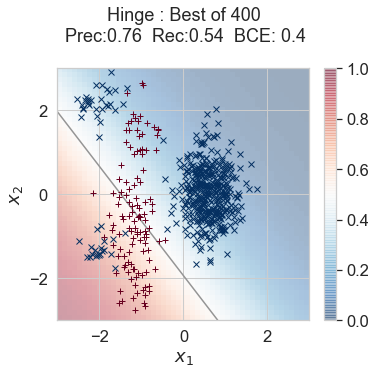

In [25]:
perf, im, cbar = visuals.pretty_plot_decision_boundary(
    best_result__hin['w_D'], x_ND, y_N,
    title_str='Hinge : Best of %d' % len(ranked_answers__hin),
    x1_ticks=[-2, 0, 2],
    x2_ticks=[-2, 0, 2],
    G=51, H=51, figsize=figsize);

## Would the hinge loss prefer the solution from sigmoid loss?

No. The best result from the Sigmoid objective has way worse score under the Hinge's loss.

In [35]:
def calc_common_hinge_loss_from_ans_dict(ans_dict):
    w_D = ans_dict['w_D']
    _, f, g, _ = hin_loss(w_D, return_parts=True)
    return calc_common_loss_from_ans_dict({'f':f, 'g':g, 'recall':ans_dict['recall']})

In [36]:
calc_common_hinge_loss_from_ans_dict(best_result__sigm)

2073778193.587796

In [37]:
calc_common_hinge_loss_from_ans_dict(best_result__hin)

22345112.125233248

In [38]:
calc_common_hinge_loss_from_ans_dict(best_result__sigm) < calc_common_hinge_loss_from_ans_dict(best_result__hin)

False

## Would the sigmoid loss prefer the solution from hinge?

No. The best result from the Sigmoid objective has way worse score under the Hinge's loss.

In [30]:
def calc_common_sigmoid_loss_from_ans_dict(ans_dict):
    w_D = ans_dict['w_D']
    _, f, g, _ = sigm_loss(w_D, return_parts=True)
    return calc_common_loss_from_ans_dict({'f':f, 'g':g, 'recall':ans_dict['recall']})

In [31]:
calc_common_sigmoid_loss_from_ans_dict(best_result__sigm)

-102.3499778078307

In [32]:
calc_common_sigmoid_loss_from_ans_dict(best_result__hin)

3892396.097734396

In [33]:
calc_common_sigmoid_loss_from_ans_dict(best_result__sigm) > calc_common_sigmoid_loss_from_ans_dict(best_result__hin)

False